In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme()
    
paths = [f.path for f in os.scandir('target/criterion/') if f.is_dir()]
paths.remove('target/criterion/report')

report = {}

for path in paths:
    path_end = path.split('/')[-1].split(' ')
    function_name = path_end[0]
    
    size_paths = [f.path for f in os.scandir(path) if f.is_dir() and not f.path.endswith('report')]
        
    for size_path in size_paths:
        size = int(size_path.split('/')[-1])
        with open(os.path.join(size_path, 'base', 'estimates.json'), 'r') as f:
            data = json.load(f)
            
            if function_name not in report:
                report[function_name] = {}
                            
            report[function_name][size] = data['median']['point_estimate']
        

In [2]:
df = pd.DataFrame(report)
df

,cost_le,cost_leq,cost_pow,cost_mod,cost_geq,cost_log2,cost_or,cost_ge,cost_sqrti,cost_and,cost_add,cost_tuple_get,cost_sub
2,1305.078539,1402.562788,1383.35945,1414.075652,1379.327519,NaN,1283.569865,1375.234633,NaN,1294.950785,1553.970464,3.587283e+03,1545.872379
1,NaN,NaN,NaN,NaN,NaN,1378.341429,NaN,NaN,1576.246444,NaN,1466.828129,3.026994e+03,1457.713791
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2685.961527,2.606711e+04,2706.519141
256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8269.797953,2.294831e+05,8332.636787
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2139.523750,1.397936e+04,2108.420272
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1834.611633,7.413163e+03,1824.996036
128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5215.869848,1.117828e+05,5292.363571
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3678.904653,5.269367e+04,3589.403817
2048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.248062e+06,NaN
4096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.648159e+06,NaN


In [3]:
def estimate_params(df, name, transform):
    X = df.index.values.reshape(-1, 1)
    Y = df[name].values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))].reshape(-1, 1)
    Y = Y[np.logical_not(np.isnan(Y))]
    X = transform(X)
#     Y = transform(Y)

    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    
    b = linear_regressor.intercept_
    if b < 0:
        b = max(Y[0] - linear_regressor.coef_, 0)
    a = linear_regressor.coef_
    
    return (a, b)
    
def logn(n):
    return np.log2(n)

def nlogn(n):
    return n * np.log2(n)

def plot(df, name, a, b, transform):
    Y = df[name].values.reshape(-1, 1)
    X = df.index.values.reshape(-1, 1)
    X = X[np.logical_not(np.isnan(Y))]
    X = transform(X)
    Y = Y[np.logical_not(np.isnan(Y))]
    
    y_pred = a*X + b
    
    plt.scatter(X, Y, color='orange')
    plt.suptitle(name)
    plt.plot(X, y_pred, color='blue')
    plt.show()

def estimate_plot(df, fun_name, output, transform = lambda x: x):
    a, b = estimate_params(df, fun_name, transform)
    output.loc[fun_name] = [a.squeeze(), b.squeeze()]
    plot(df, fun_name, a, b, transform)

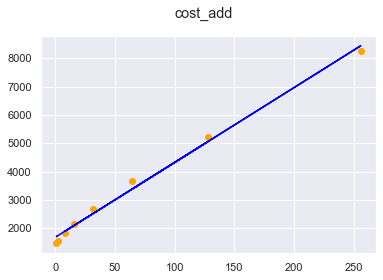

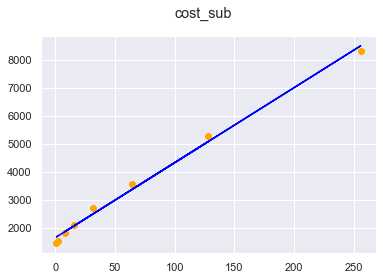

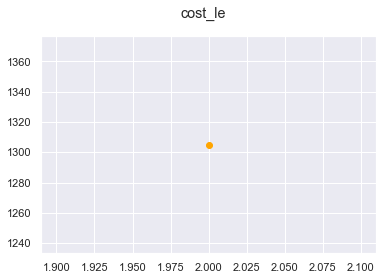

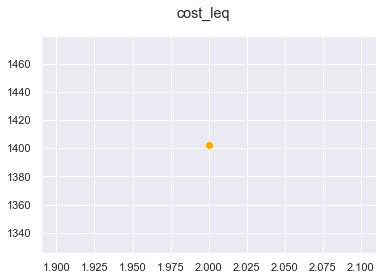

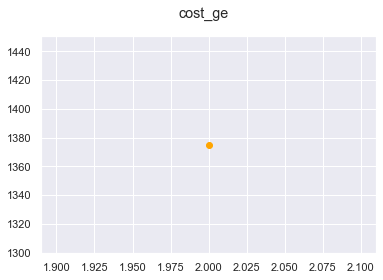

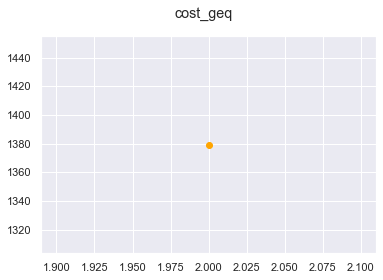

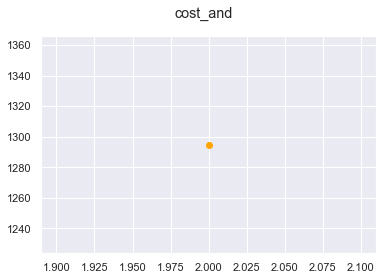

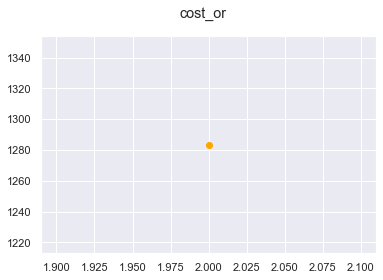

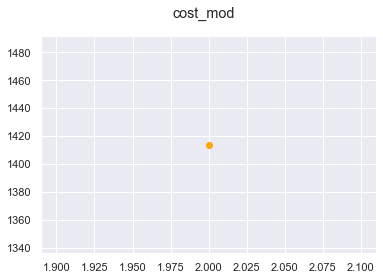

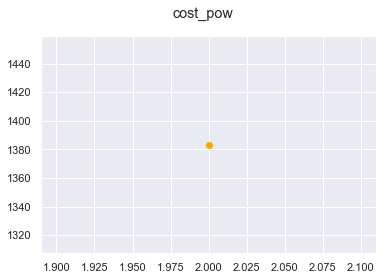

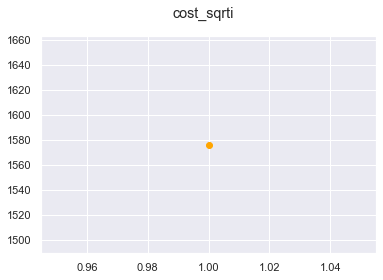

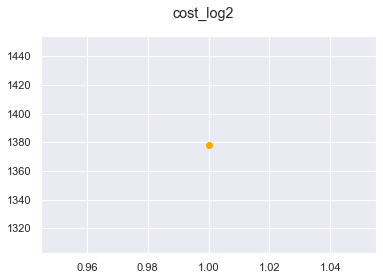

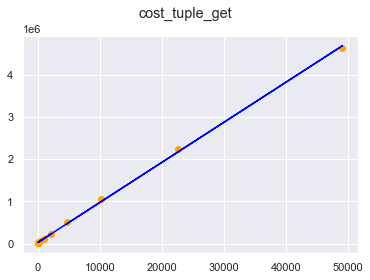

,a,b
cost_add,26.401421114068345,1682.493431
cost_sub,26.752986556639343,1661.770201
cost_le,0.0,1305.078539
cost_leq,0.0,1402.562788
cost_ge,0.0,1375.234633
cost_geq,0.0,1379.327519
cost_and,0.0,1294.950785
cost_or,0.0,1283.569865
cost_mod,0.0,1414.075652
cost_pow,0.0,1383.359450


In [4]:
output = pd.DataFrame(columns=["a", "b"])

estimate_plot(df, 'cost_add', output)
estimate_plot(df, 'cost_sub', output)
estimate_plot(df, 'cost_le', output)
estimate_plot(df, 'cost_leq', output)
estimate_plot(df, 'cost_ge', output)
estimate_plot(df, 'cost_geq', output)
estimate_plot(df, 'cost_and', output)
estimate_plot(df, 'cost_or', output)
estimate_plot(df, 'cost_mod', output)
estimate_plot(df, 'cost_pow', output)
estimate_plot(df, 'cost_sqrti', output)
estimate_plot(df, 'cost_log2', output)
estimate_plot(df, 'cost_tuple_get', output, nlogn)

output

In [5]:
output.to_csv("cost_constants.csv")

In [9]:
71241.3539776112 2.126736e+07

SyntaxError: invalid syntax (<ipython-input-9-1110dabad65a>, line 1)